In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Define the paths to the CSV files
train_csv_path = '/content/drive/My Drive/words1_train.csv'
test_csv_path = '/content/drive/My Drive/words1_test.csv'

# Load the DataFrames from CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display the first few rows of the DataFrames
print("Training Data:")
print(train_df.head())

print("Testing Data:")
print(test_df.head())


Mounted at /content/drive
Training Data:
                                           file_path     label
0  /content/drive/My Drive/words1/a01/a01-128/a01...   a01-128
1  /content/drive/My Drive/words1/a01/a01-038x/a0...  a01-038x
2  /content/drive/My Drive/words1/a01/a01-122/a01...   a01-122
3  /content/drive/My Drive/words1/a01/a01-038/a01...   a01-038
4  /content/drive/My Drive/words1/a01/a01-003/a01...   a01-003
Testing Data:
                                           file_path     label
0  /content/drive/My Drive/words1/a01/a01-003u/a0...  a01-003u
1  /content/drive/My Drive/words1/a01/a01-058u/a0...  a01-058u
2  /content/drive/My Drive/words1/a01/a01-007u/a0...  a01-007u
3  /content/drive/My Drive/words1/a01/a01-087/a01...   a01-087
4  /content/drive/My Drive/words1/a01/a01-077u/a0...  a01-077u


In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import os

# Function to load and preprocess images
def preprocess_image(image_path, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image = tf.image.resize(image, img_size)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    return image

# Function to vectorize labels
def vectorize_label(label, char_to_num, num_classes):
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    label = tf.one_hot(label, depth=num_classes)
    label = tf.reduce_sum(label, axis=0)  # Sum the one-hot encodings to form a single vector
    return label

# Prepare dataset with validation checks
def prepare_dataset(df, char_to_num, num_classes):
    valid_paths = []
    valid_labels = []

    for path, label in zip(df['file_path'].values, df['label'].values):
        if os.path.exists(path) and os.path.getsize(path) > 0:
            valid_paths.append(path)
            valid_labels.append(label)

    dataset = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))

    def process_path(file_path, label):
        image = preprocess_image(file_path)
        label = vectorize_label(label, char_to_num, num_classes)
        return image, label

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Get unique characters
characters = set(char for label in train_df['label'] for char in label)
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_classes = len(char_to_num.get_vocabulary()) + 1

# Create TensorFlow datasets
train_dataset = prepare_dataset(train_df, char_to_num, num_classes)
test_dataset = prepare_dataset(test_df, char_to_num, num_classes)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_cnn_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model(num_classes)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

122/122 [==============================] - 355s 3s/step - loss: 2981655808.0000 - accuracy: 0.7726 - val_loss: 16456059904.0000 - val_accuracy: 0.7487


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


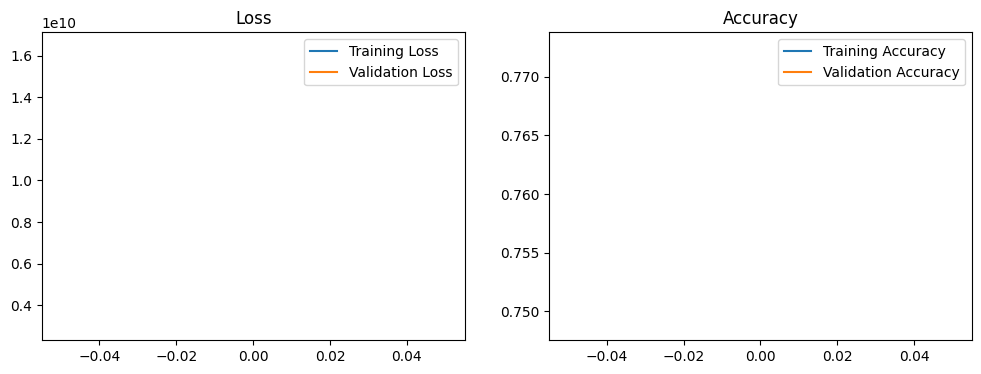

In [ ]:
# Train the CNN model
history = cnn_model.fit(train_dataset, validation_data=test_dataset, epochs=1)

# Save the model to Google Drive
model_save_path = '/content/drive/My Drive/handwriting_recognizer_cnn_model.h5'
cnn_model.save(model_save_path)

# Plotting the accuracy and loss
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_metrics(history)


prediction using trained model


In [5]:
# Load the pre-trained CNN model
model = tf.keras.models.load_model('/content/drive/My Drive/handwriting_recognizer_cnn_model.h5')

# Make predictions on the test data
predictions = model.predict(test_dataset)

31/31 [==============================] - 131s 4s/step


In [ ]:
# no need
import pandas as pd

# Read the train CSV file
train_df = pd.read_csv('/content/drive/My Drive/words1_train.csv')

# Read the test CSV file
test_df = pd.read_csv('/content/drive/My Drive/words1_test.csv')

# Print the first few rows of the train DataFrame
print(train_df.head())

# Print the first few rows of the test DataFrame
print(test_df.head())

                                           file_path     label
0  /content/drive/My Drive/words1/a01/a01-128/a01...   a01-128
1  /content/drive/My Drive/words1/a01/a01-038x/a0...  a01-038x
2  /content/drive/My Drive/words1/a01/a01-122/a01...   a01-122
3  /content/drive/My Drive/words1/a01/a01-038/a01...   a01-038
4  /content/drive/My Drive/words1/a01/a01-003/a01...   a01-003
                                           file_path     label
0  /content/drive/My Drive/words1/a01/a01-003u/a0...  a01-003u
1  /content/drive/My Drive/words1/a01/a01-058u/a0...  a01-058u
2  /content/drive/My Drive/words1/a01/a01-007u/a0...  a01-007u
3  /content/drive/My Drive/words1/a01/a01-087/a01...   a01-087
4  /content/drive/My Drive/words1/a01/a01-077u/a0...  a01-077u


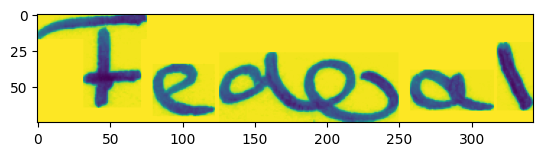

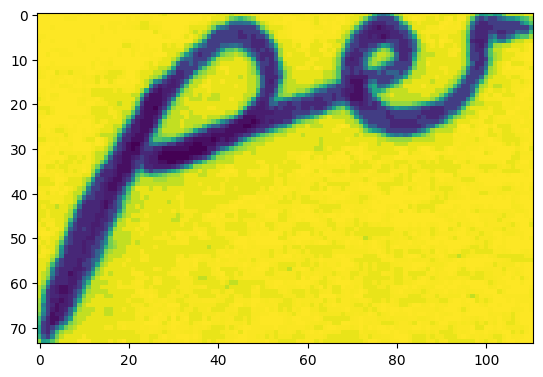

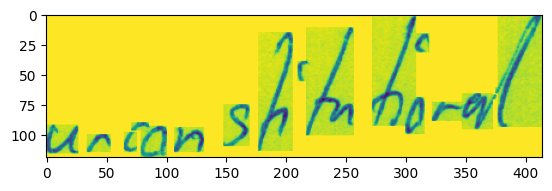

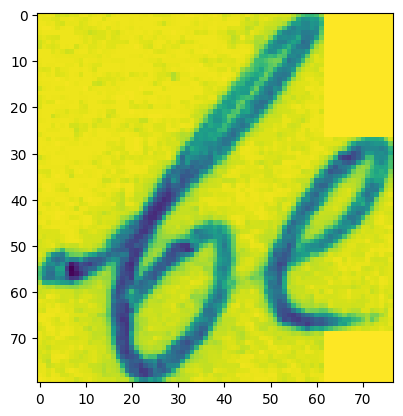

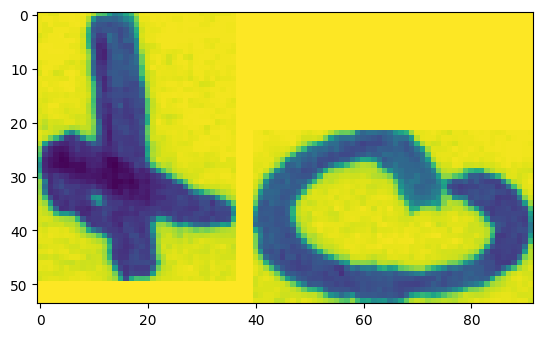

In [ ]:
# no need
import numpy as np

# Get the number of images in the test dataset
num_test_images = len(test_df)

# Choose a random sample of images to display
random_indices = np.random.randint(0, num_test_images, size=5)

# Iterate through the random indices and display the corresponding images
for i in random_indices:
    # Get the file path of the image
    image_path = test_df.loc[i, 'file_path']

    # Read the image
    image = plt.imread(image_path)

    # Print the image
    plt.imshow(image)
    plt.show()

In [ ]:
model.input_shape # no need

(None, 224, 224, 3)

In [ ]:
input_data_shape = test_dataset.element_spec[0].shape  #no need
print(f"Input data shape: {input_data_shape}")

Input data shape: (1, 224, 224, 3)


In [ ]:
from tensorflow.keras.layers import Reshape  # no need

In [ ]:
# no need
model = tf.keras.models.load_model('/content/drive/My Drive/handwriting_recognizer_cnn_model.h5', custom_objects={'MyReshape': Reshape(target_shape=(224, 224, 3))})

In [ ]:
# no need
# Import the Reshape class
from tensorflow.keras.layers import Reshape

# Load the model with the custom Reshape class
model = tf.keras.models.load_model('/content/drive/My Drive/handwriting_recognizer_cnn_model.h5', custom_objects={'Reshape': Reshape(target_shape=(224, 224, 3))})

# Check if the model loaded successfully
print(f"Model loaded successfully: {model is not None}")

Model loaded successfully: True


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Read the test data
test_df = pd.read_csv('/content/drive/My Drive/words1_test.csv')

# Define the image generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/drive/My Drive/',
    x_col='file_path',
    y_col='label',  # Change this to the correct column name
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
# Check the data type of the 'label' column
test_df['label'].dtype

# If the data type is not correct, convert it
test_df['label'] = test_df['label'].astype('str')

# Make predictions on the test data
predictions = model.predict(test_generator)

# Print the predictions
print(predictions)
# print("Accuracy:", accuracy)


Found 971 validated image filenames belonging to 66 classes.
31/31 [==============================] - 23s 738ms/step
[[0.         0.99999994 0.         ... 0.         0.         0.        ]
 [0.         0.99999994 0.         ... 0.         0.         0.        ]
 [0.         0.99999994 0.         ... 0.         0.         0.        ]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]]


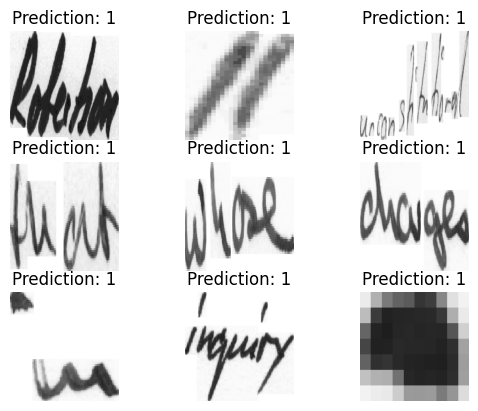

In [7]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_generator[0][0][i])
    plt.title(f"Prediction: {np.argmax(predictions[i])}")
    plt.axis('off')

plt.show()

In [ ]:
test_df['label'].dtype  # no need

dtype('O')

In [ ]:
test_df['label'].head()   # no need

0    a01-003u
1    a01-058u
2    a01-007u
3     a01-087
4    a01-077u
Name: label, dtype: object

In [ ]:
test_df['label'] = test_df['label'].astype('str')   # no need

In [ ]:
test_df['label'].dtype  3 no need

dtype('O')

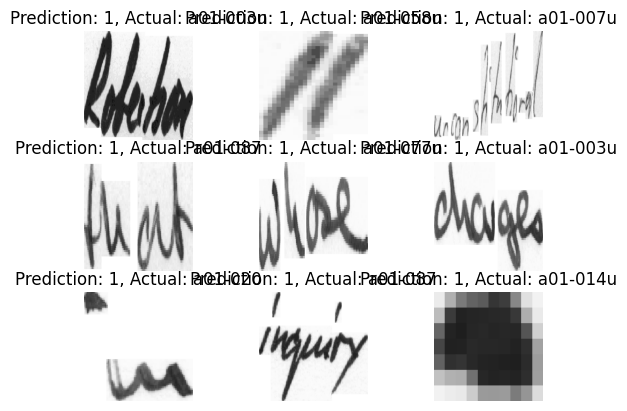

In [8]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_generator[0][0][i])
    plt.title(f"Prediction: {np.argmax(predictions[i])}, Actual: {test_df['label'].iloc[i]}")
    plt.axis('off')

plt.show()

In [ ]:
GAN-CNN code

In [ ]:
#  no need
# Import necessary libraries
from tensorflow.keras.models import load_model

# Load the original CNN model
original_cnn_model = load_model("/content/drive/MyDrive/handwriting_recognizer_cnn_model.h5")

# Create a copy of the CNN model
gan_cnn_model = keras.models.clone_model(original_cnn_model)

# Save the copied model as "gan_cnn.h5" in your Google Drive
gan_cnn_model.save("/content/drive/MyDrive/gan_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create directory for saving generated images
save_dir = '/content/drive/My Drive/generated_images/'
os.makedirs(save_dir, exist_ok=True)

print(f"Created directory: {save_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created directory: /content/drive/My Drive/generated_images/


In [76]:
from tensorflow.keras.models import load_model

# Load the pre-trained CNN model
cnn_model_path = '/content/drive/MyDrive/handwriting_recognizer_cnn_model.h5'
cnn_model = load_model(cnn_model_path)
cnn_model.trainable = False  # Make the CNN model non-trainable during GAN training

print("Loaded pre-trained CNN model.")


Loaded pre-trained CNN model.


In [77]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the generator
def build_generator():
    model = Sequential()
    model.add(layers.Dense(128, input_dim=100, activation='relu'))
    model.add(layers.Reshape((8, 8, 2)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2D(1, (7, 7), activation='tanh', padding='same'))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Build and compile the GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(), loss='binary_crossentropy')


In [78]:
import numpy as np
import matplotlib.pyplot as plt

def train_gan_with_cnn(generator, discriminator, gan, cnn_model, test_generator, epochs=1, batch_size=64):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)

        real_images, _ = next(test_generator)
        real_images = real_images[:batch_size]

        if real_images.shape[0] != generated_images.shape[0]:
            continue

        combined_images = np.concatenate([generated_images, real_images])
        labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)

        d_loss = discriminator.train_on_batch(combined_images, labels)

        noise = np.random.normal(0, 1, (batch_size, 100))
        misleading_targets = np.ones((batch_size, 1))

        a_loss = gan.train_on_batch(noise, misleading_targets)

        print(f"epoch: {epoch}, d_loss: {d_loss}, a_loss: {a_loss}")

        # Evaluate the generator using the CNN model
        generated_images = generator.predict(noise)
        cnn_predictions = cnn_model.predict(generated_images)
        print("CNN Model Predictions on Generated Images:")
        print(cnn_predictions)

        # Save generated images for this epoch
        for i, img in enumerate(generated_images):
            plt.imsave(f'{save_dir}generated_image_epoch{epoch}_{i}.png', img.reshape(64, 64), cmap='gray')

        print(f'Saved generated images for epoch {epoch} to {save_dir}')

    # Save the generator model
    generator.save('/content/drive/My Drive/gan_model_generator.h5')

    # Save the discriminator model
    discriminator.save('/content/drive/My Drive/gan_model_discriminator.h5')

    # Save the combined GAN model
    gan.save('/content/drive/My Drive/gan_model.h5')
    print('Saved GAN model to /content/drive/My Drive/gan_model.h5')

# Assume test_generator is defined and initialized
train_gan_with_cnn(generator, discriminator, gan, cnn_model, test_generator, epochs=1, batch_size=64)


2/2 [==============================] - 1s 249ms/step


Saved GAN model to /content/drive/My Drive/gan_model.h5


In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 new images using the generator
noise = np.random.normal(0, 1, (100, 100))
new_generated_images = generator.predict(noise)

# Save new generated images
for i, img in enumerate(new_generated_images):
    plt.imsave(f'{save_dir}new_generated_image_{i}.png', img.reshape(64, 64), cmap='gray')

print(f'Saved 100 new generated images to {save_dir}')


4/4 [==============================] - 1s 121ms/step
Saved 100 new generated images to /content/drive/My Drive/generated_images/


In [81]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
cnn_model = load_model('/content/drive/MyDrive/handwriting_recognizer_cnn_model.h5')

# Load the GAN generator model
gan_generator = load_model('/content/drive/My Drive/gan_model_generator.h5')

# Load the GAN discriminator model (if needed)
gan_discriminator = load_model('/content/drive/My Drive/gan_model_discriminator.h5')


In [86]:
# Predict with the pre-trained CNN model on new generated images
cnn_predictions = cnn_model.predict(new_generated_images)

# Print and display predictions for the CNN model
print("Pre-trained CNN Model Predictions on New Generated Images:")
for i, prediction in enumerate(cnn_predictions):
    print(f"Image {i}: Prediction: {prediction}")
    plt.imshow(new_generated_images[i].reshape(64, 64), cmap='gray')
    plt.title(f'CNN Prediction: {prediction}')
    plt.show()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 64, 64, 1)


4/4 [==============================] - 0s 66ms/step
GAN Discriminator Predictions on New Generated Images:
Image 0: Discriminator Prediction: [0.49991372]


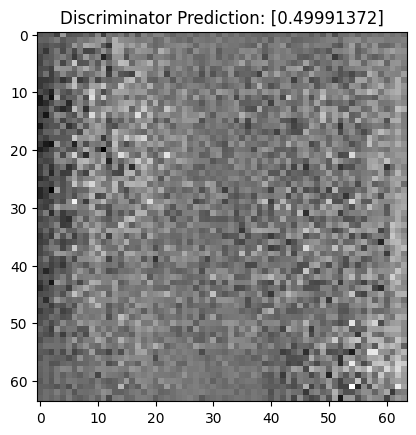

Image 1: Discriminator Prediction: [0.4997687]


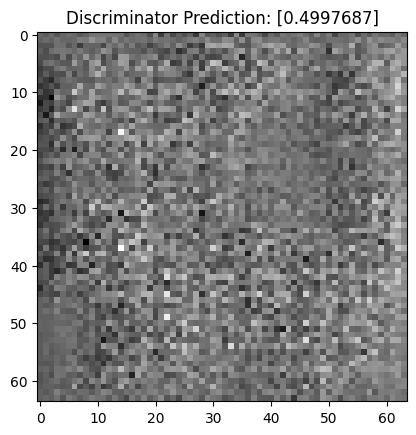

Image 2: Discriminator Prediction: [0.49986166]


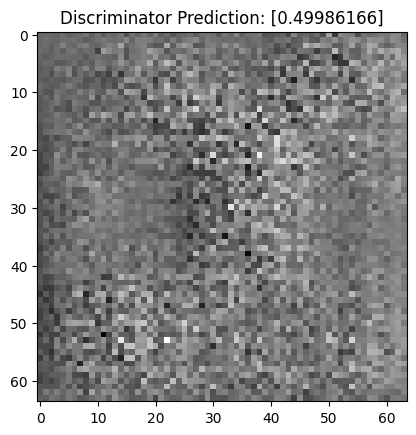

Image 3: Discriminator Prediction: [0.49992785]


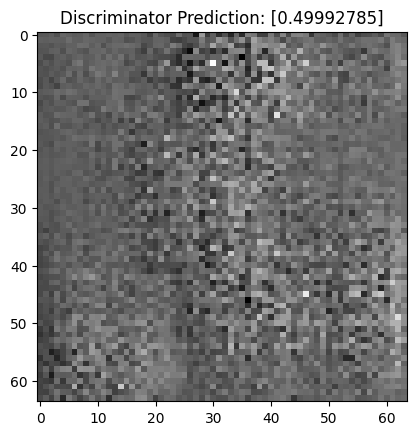

Image 4: Discriminator Prediction: [0.49992678]


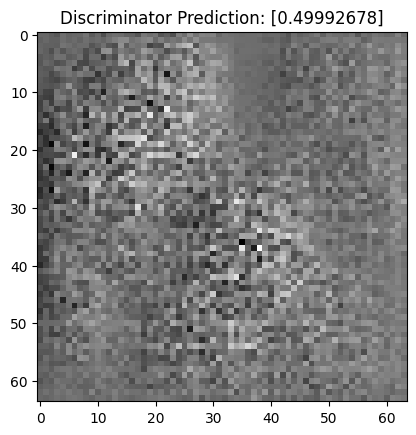

Image 5: Discriminator Prediction: [0.49979377]


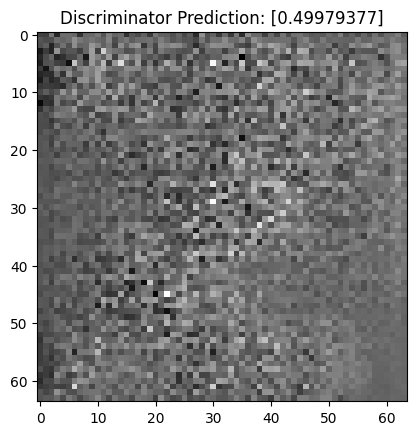

Image 6: Discriminator Prediction: [0.49985054]


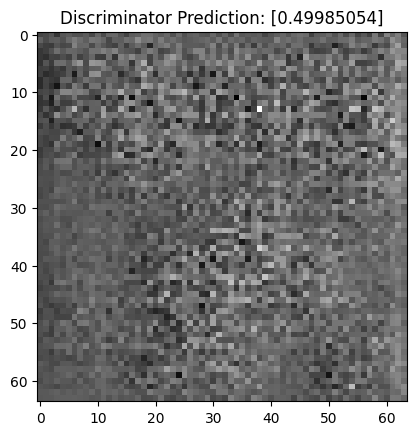

Image 7: Discriminator Prediction: [0.49987096]


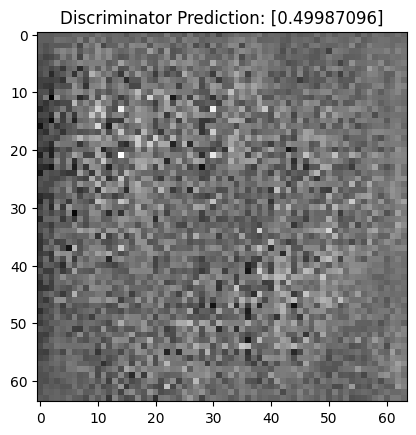

Image 8: Discriminator Prediction: [0.49987]


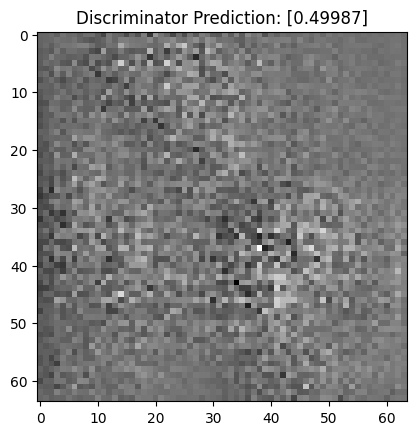

Image 9: Discriminator Prediction: [0.50014377]


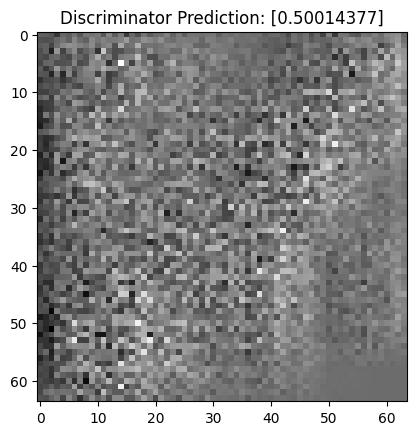

Image 10: Discriminator Prediction: [0.49983326]


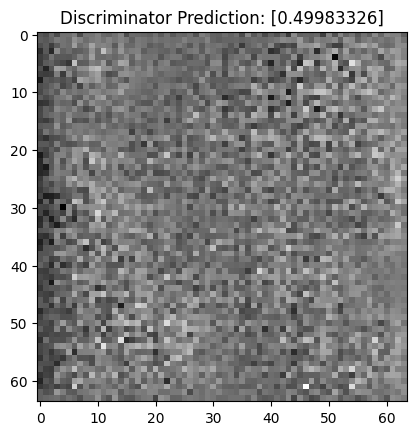

Image 11: Discriminator Prediction: [0.5000967]


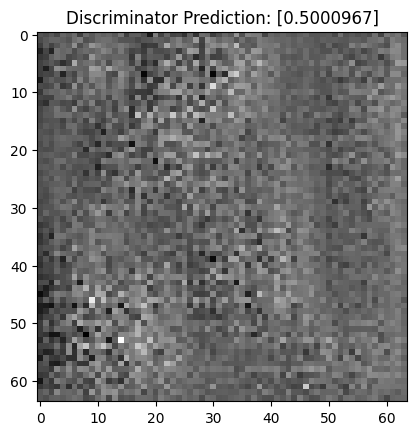

Image 12: Discriminator Prediction: [0.4998846]


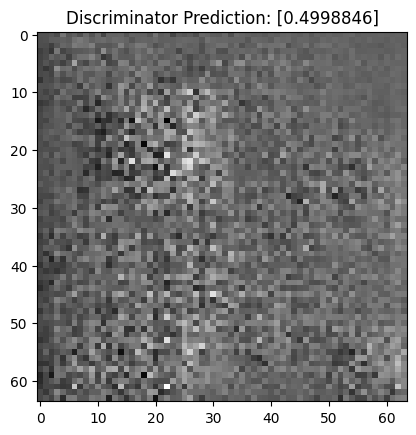

Image 13: Discriminator Prediction: [0.49995267]


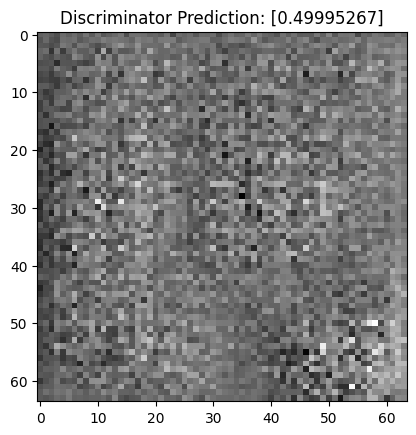

Image 14: Discriminator Prediction: [0.49979287]


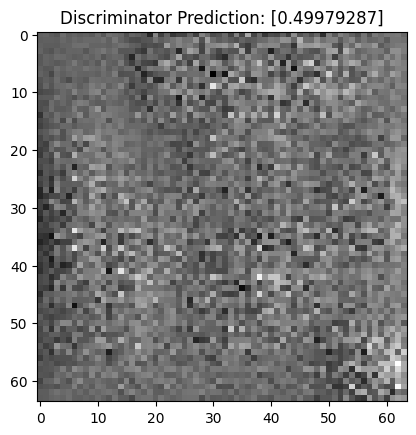

Image 15: Discriminator Prediction: [0.49978688]


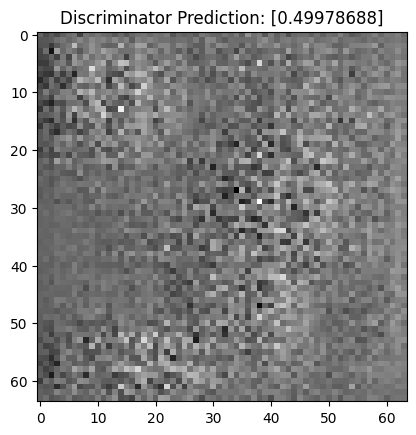

Image 16: Discriminator Prediction: [0.49998143]


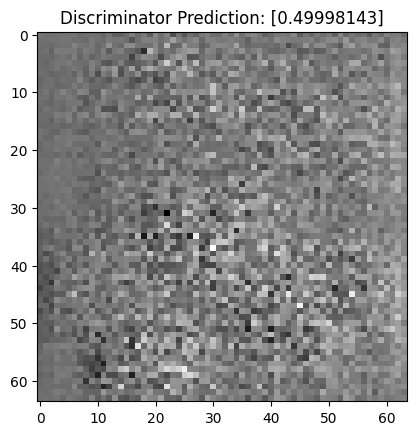

Image 17: Discriminator Prediction: [0.49985623]


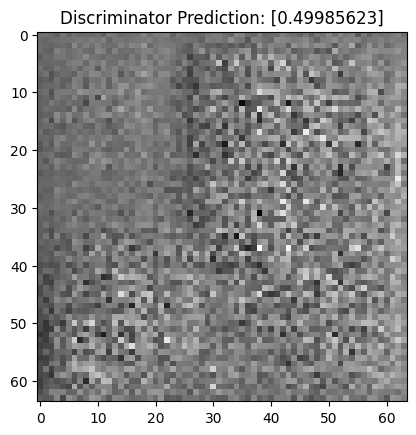

Image 18: Discriminator Prediction: [0.49969408]


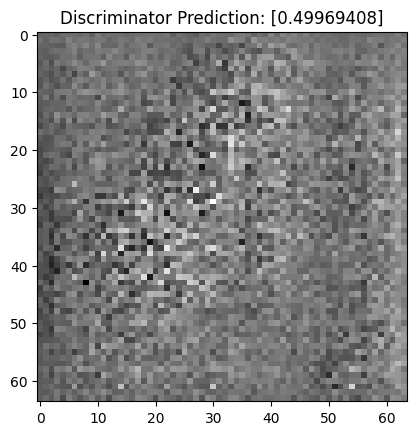

Image 19: Discriminator Prediction: [0.4997097]


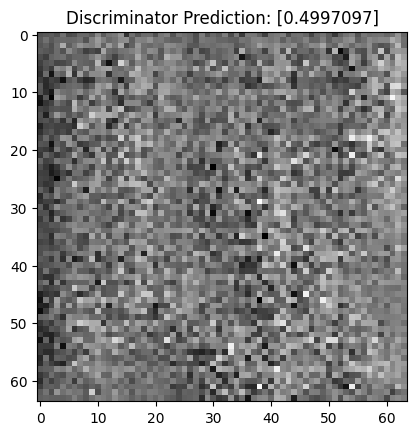

Image 20: Discriminator Prediction: [0.49972475]


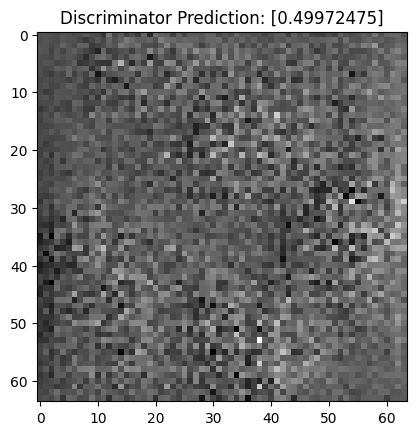

Image 21: Discriminator Prediction: [0.49997362]


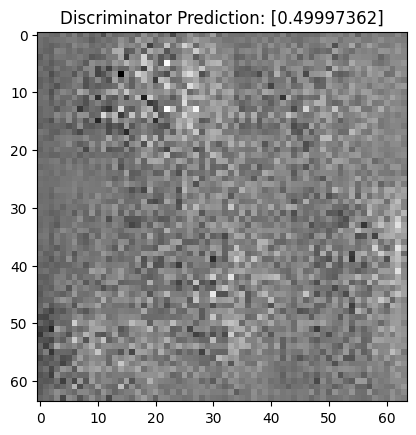

Image 22: Discriminator Prediction: [0.49993607]


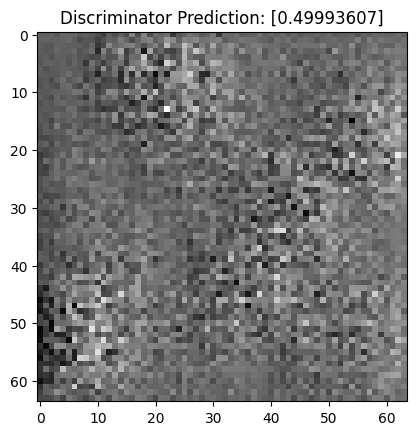

Image 23: Discriminator Prediction: [0.49990845]


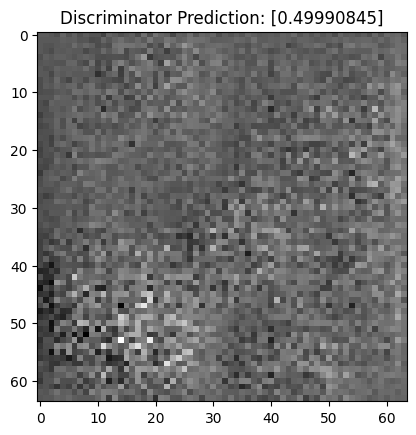

Image 24: Discriminator Prediction: [0.49993953]


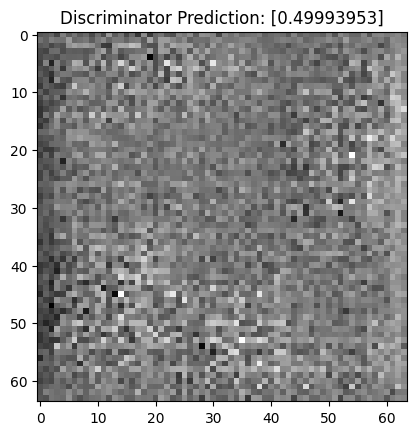

Image 25: Discriminator Prediction: [0.49982184]


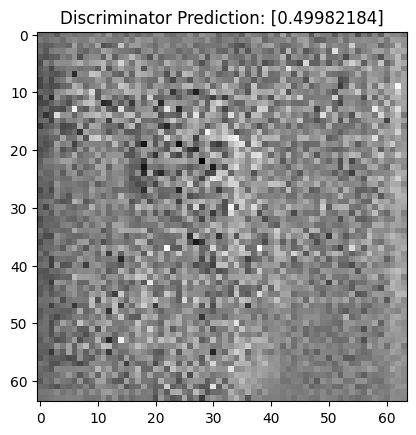

Image 26: Discriminator Prediction: [0.49985066]


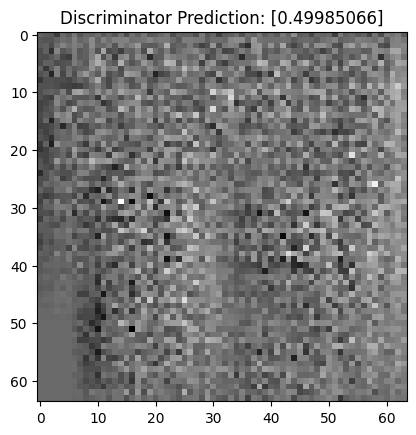

Image 27: Discriminator Prediction: [0.4998397]


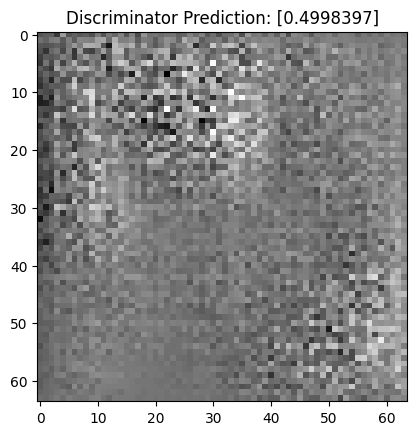

Image 28: Discriminator Prediction: [0.49973604]


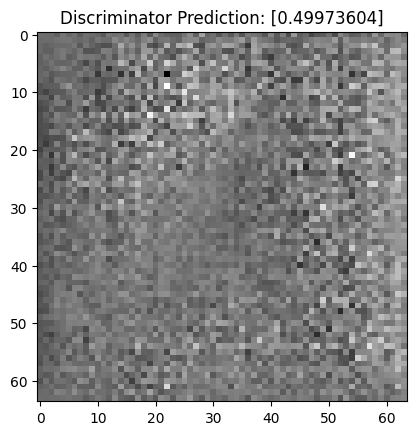

Image 29: Discriminator Prediction: [0.4999651]


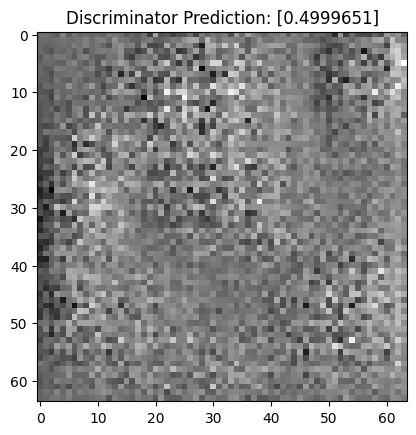

Image 30: Discriminator Prediction: [0.49984673]


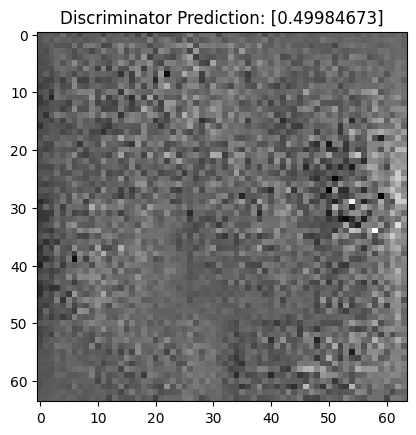

Image 31: Discriminator Prediction: [0.49977037]


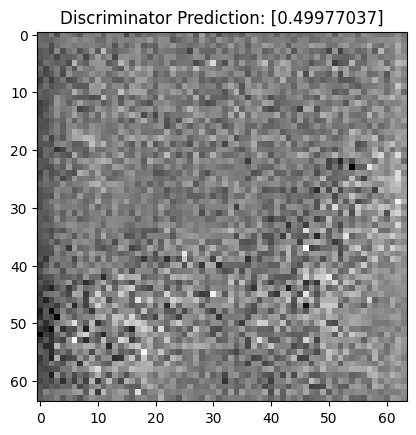

Image 32: Discriminator Prediction: [0.5000426]


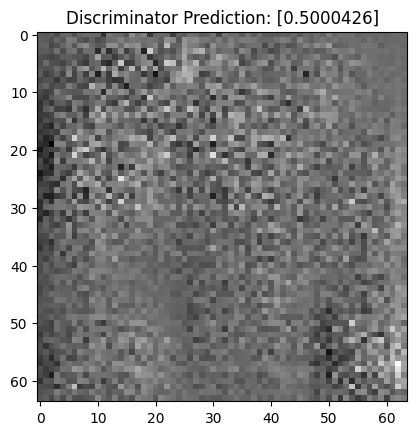

Image 33: Discriminator Prediction: [0.49983242]


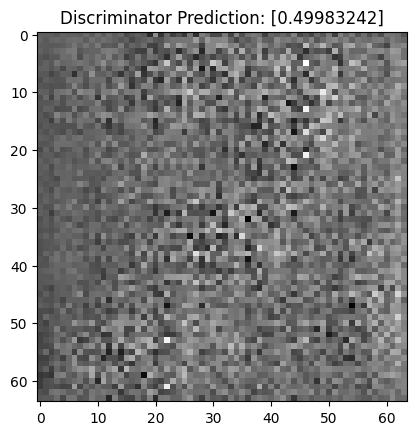

Image 34: Discriminator Prediction: [0.49997827]


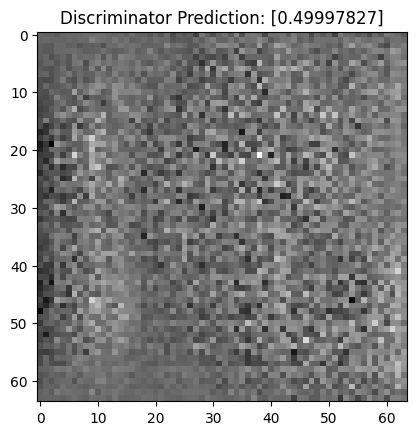

Image 35: Discriminator Prediction: [0.4999685]


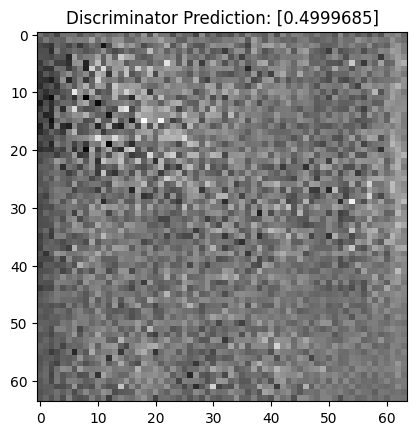

Image 36: Discriminator Prediction: [0.5000519]


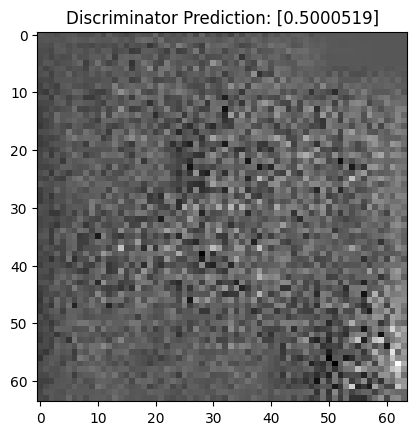

Image 37: Discriminator Prediction: [0.49984095]


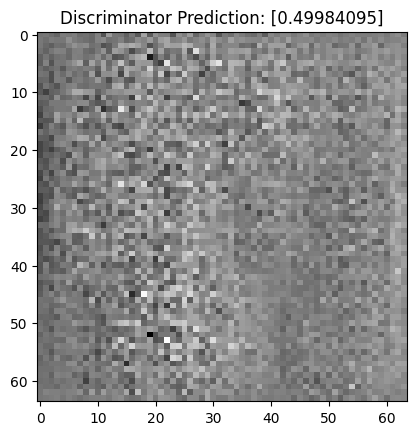

Image 38: Discriminator Prediction: [0.49999174]


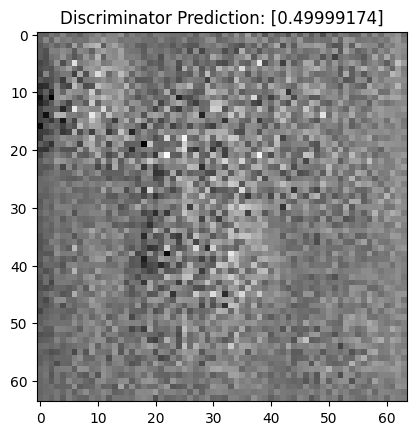

Image 39: Discriminator Prediction: [0.49995014]


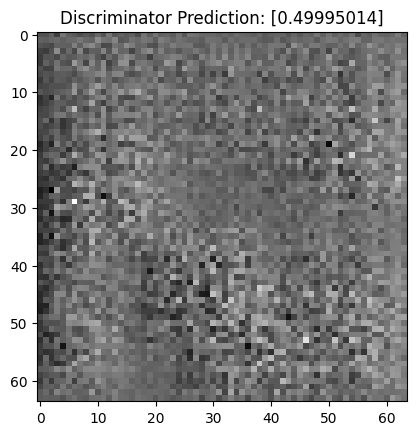

Image 40: Discriminator Prediction: [0.49994567]


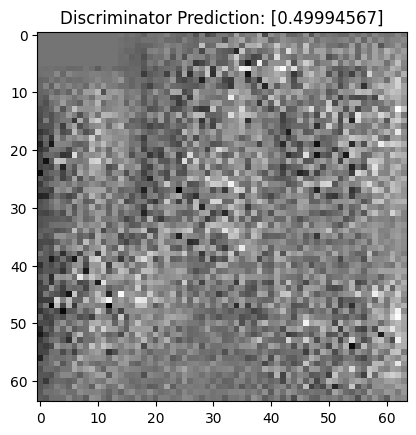

Image 41: Discriminator Prediction: [0.49986768]


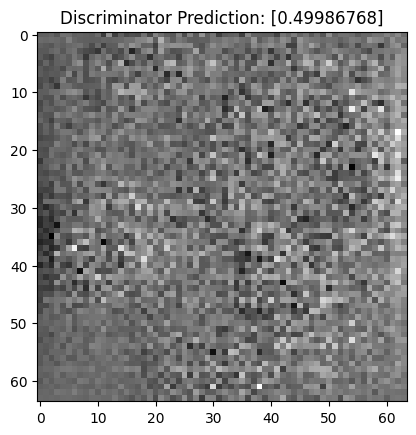

Image 42: Discriminator Prediction: [0.49963903]


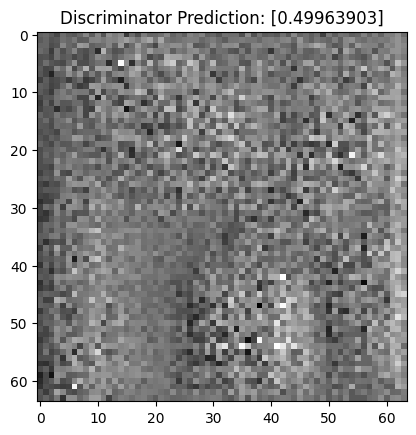

Image 43: Discriminator Prediction: [0.4997757]


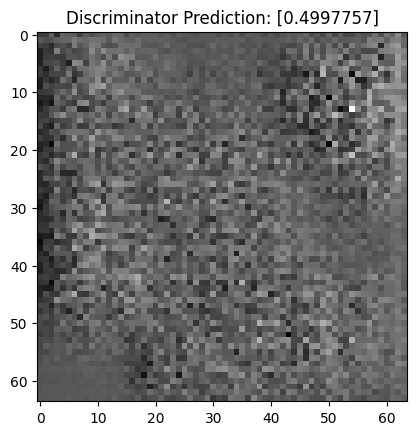

Image 44: Discriminator Prediction: [0.49996385]


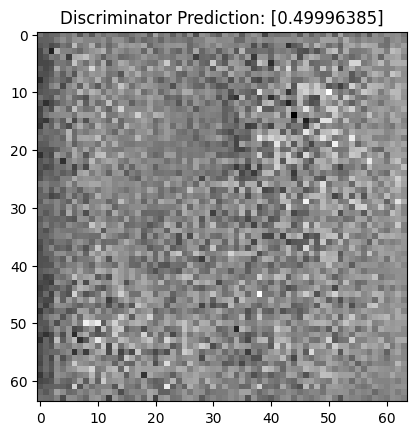

Image 45: Discriminator Prediction: [0.49972105]


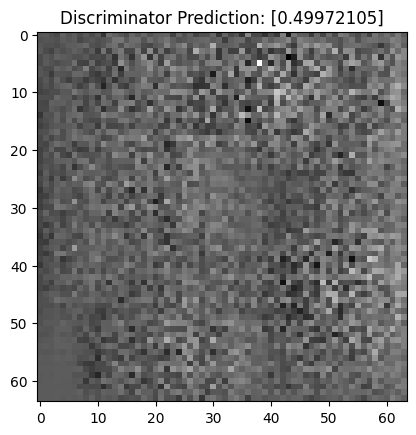

Image 46: Discriminator Prediction: [0.49998036]


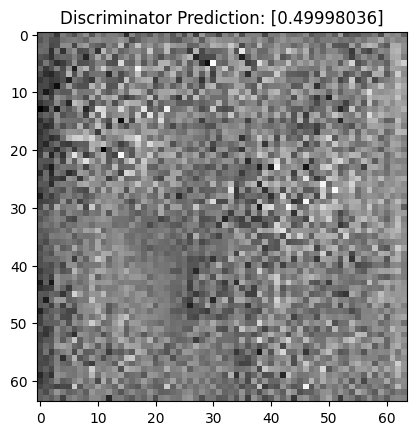

Image 47: Discriminator Prediction: [0.49976167]


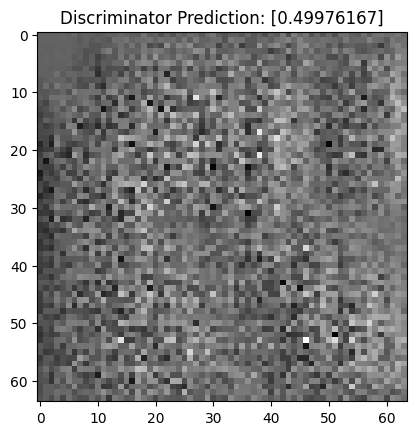

Image 48: Discriminator Prediction: [0.49968028]


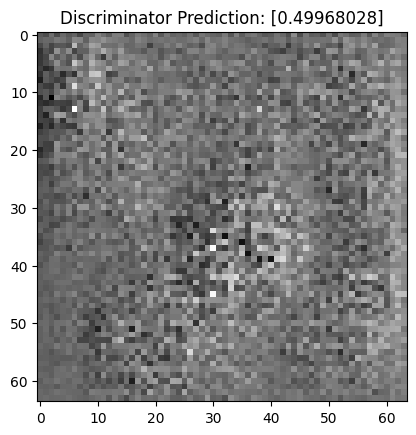

Image 49: Discriminator Prediction: [0.49986553]


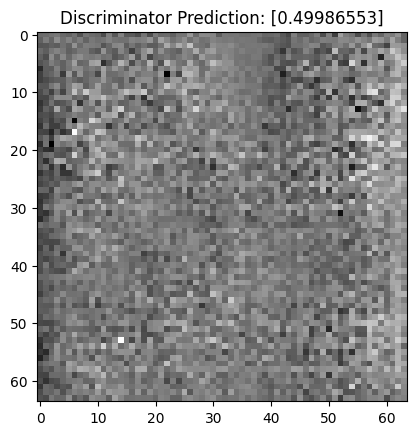

Image 50: Discriminator Prediction: [0.49987662]


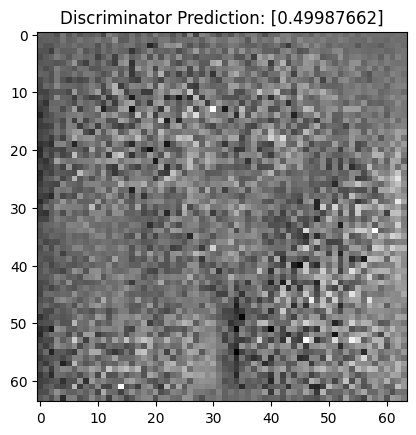

Image 51: Discriminator Prediction: [0.5001655]


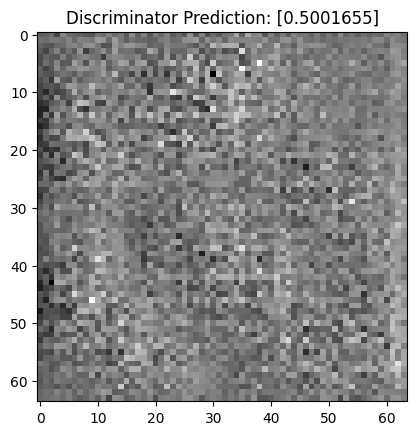

Image 52: Discriminator Prediction: [0.49990004]


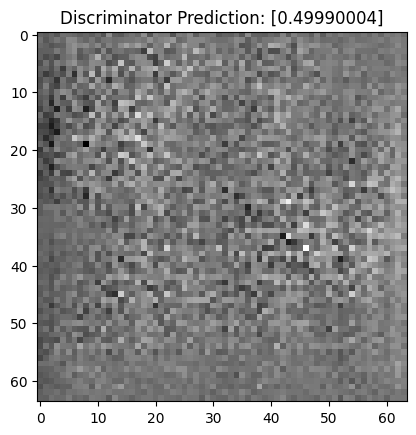

Image 53: Discriminator Prediction: [0.49989972]


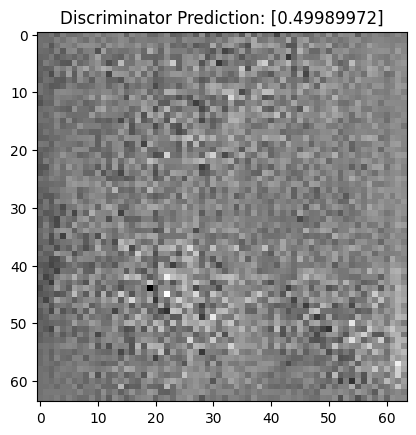

Image 54: Discriminator Prediction: [0.49958903]


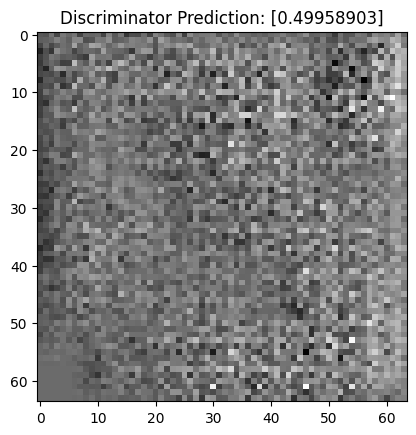

Image 55: Discriminator Prediction: [0.49993873]


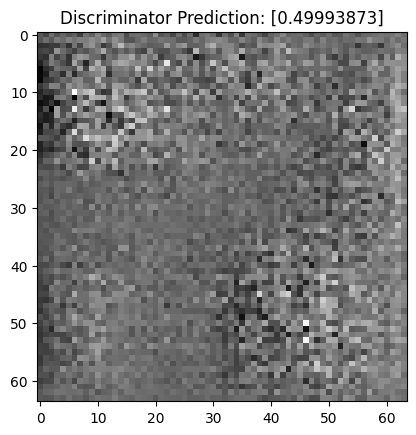

Image 56: Discriminator Prediction: [0.49982986]


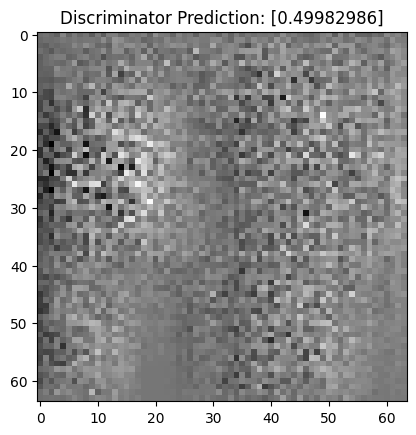

Image 57: Discriminator Prediction: [0.49961916]


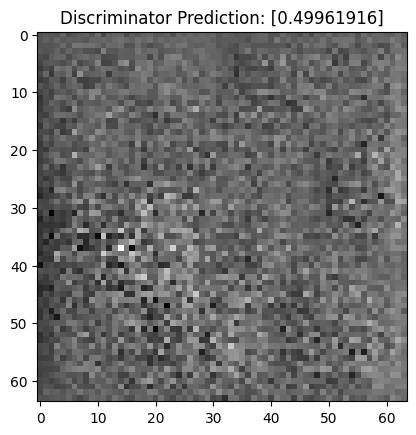

Image 58: Discriminator Prediction: [0.49974817]


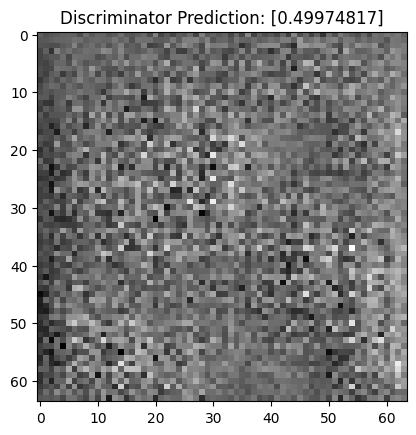

Image 59: Discriminator Prediction: [0.4998105]


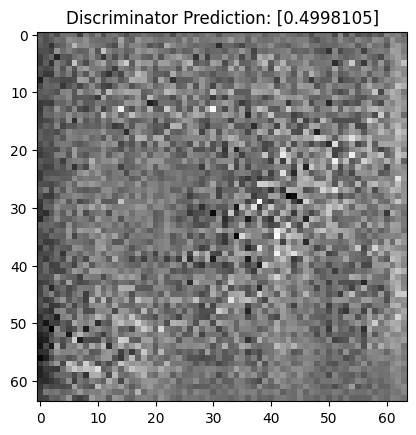

Image 60: Discriminator Prediction: [0.50002533]


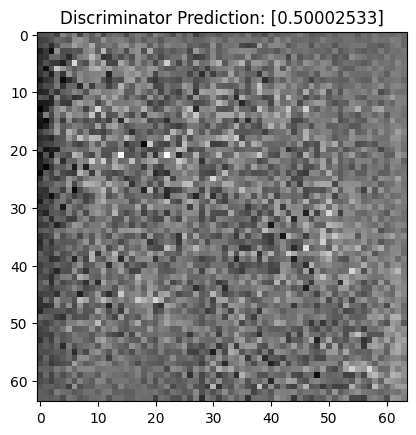

Image 61: Discriminator Prediction: [0.49992952]


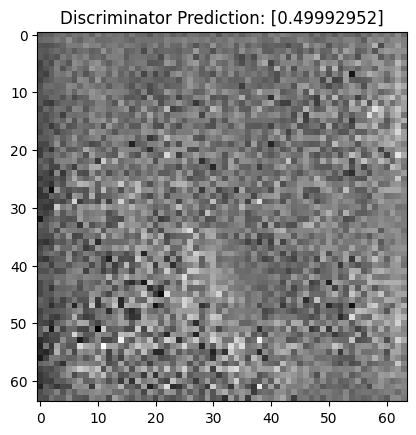

Image 62: Discriminator Prediction: [0.49986297]


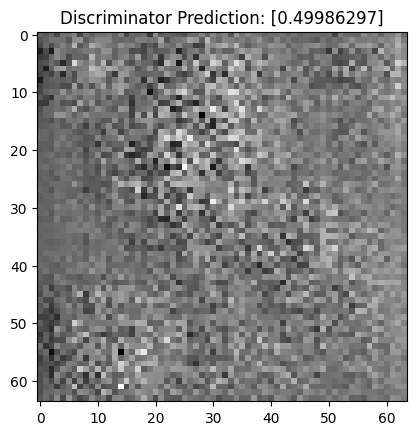

Image 63: Discriminator Prediction: [0.49991783]


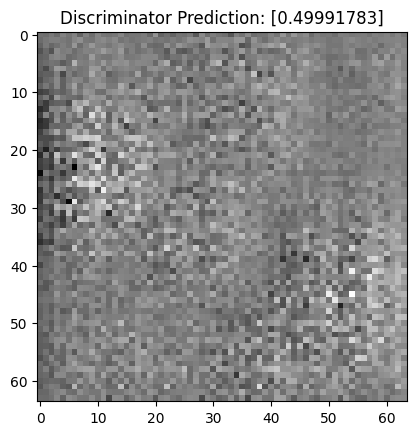

Image 64: Discriminator Prediction: [0.49991468]


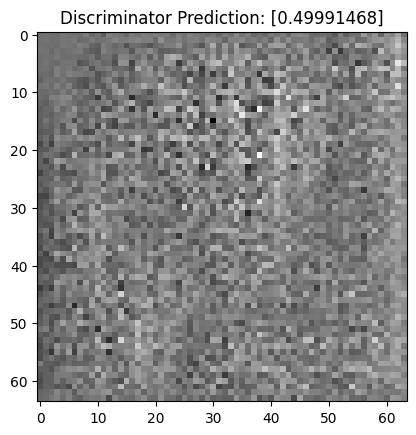

Image 65: Discriminator Prediction: [0.49986178]


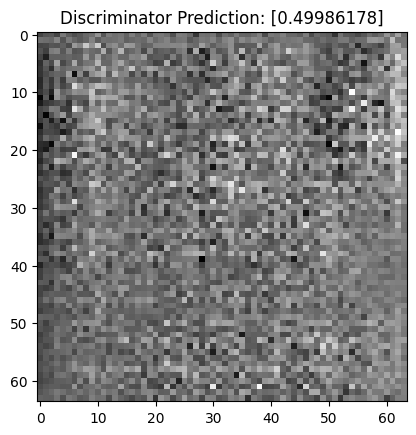

Image 66: Discriminator Prediction: [0.49978143]


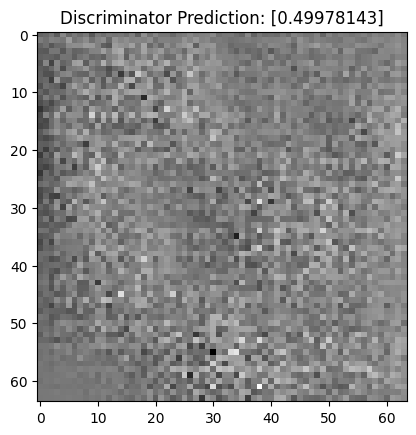

Image 67: Discriminator Prediction: [0.49998885]


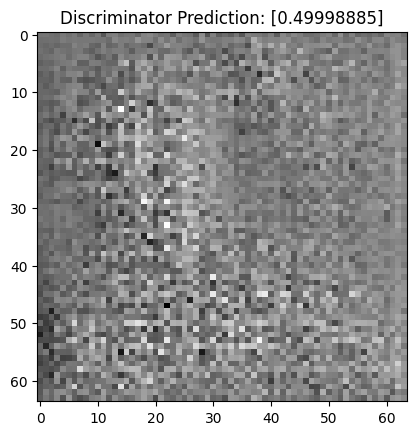

Image 68: Discriminator Prediction: [0.4998929]


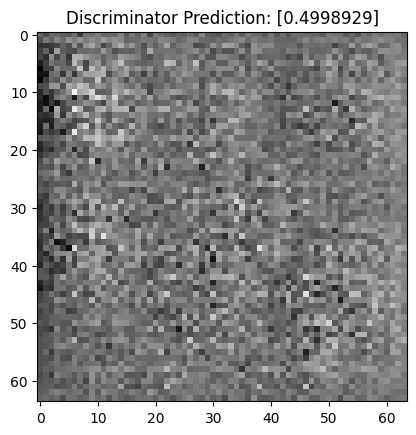

Image 69: Discriminator Prediction: [0.4997378]


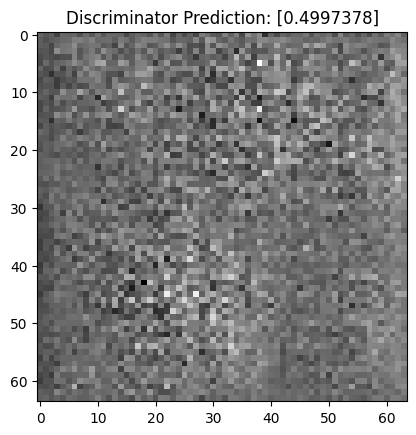

Image 70: Discriminator Prediction: [0.4999318]


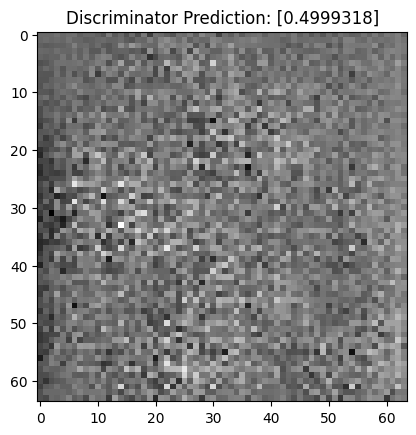

Image 71: Discriminator Prediction: [0.4998435]


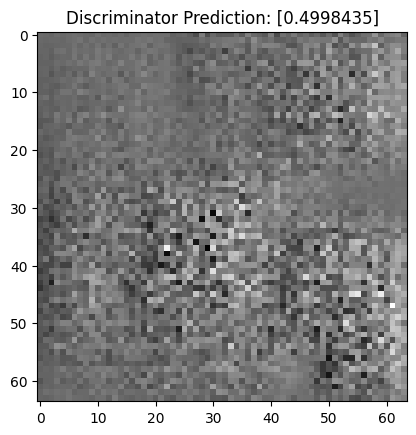

Image 72: Discriminator Prediction: [0.5000588]


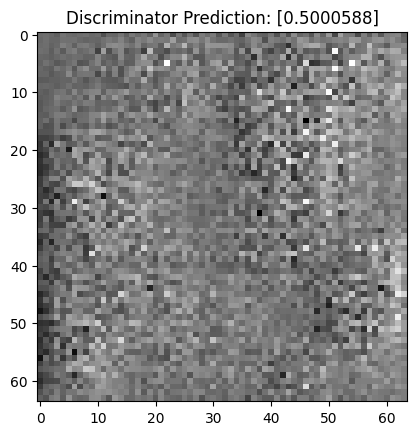

Image 73: Discriminator Prediction: [0.49999282]


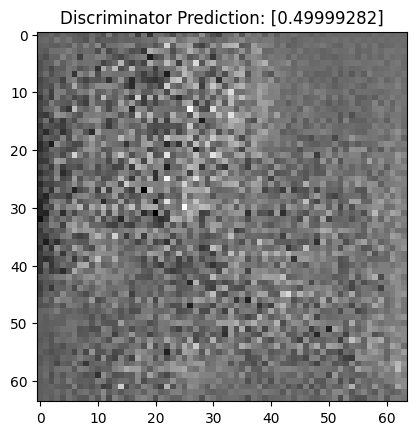

Image 74: Discriminator Prediction: [0.49995103]


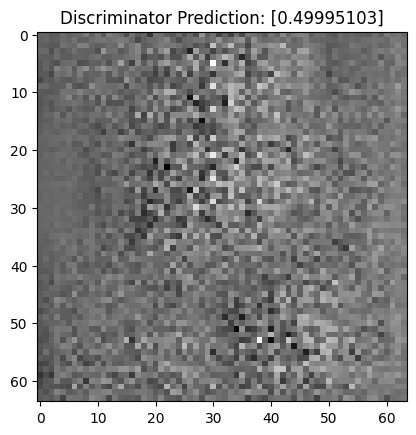

Image 75: Discriminator Prediction: [0.49991333]


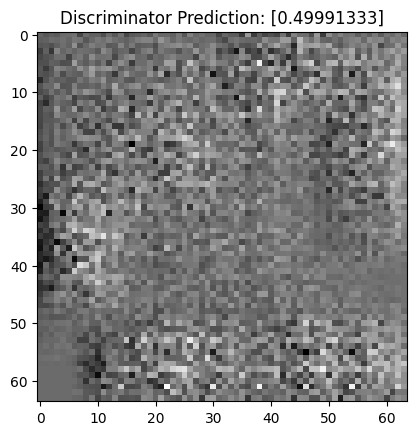

Image 76: Discriminator Prediction: [0.5000585]


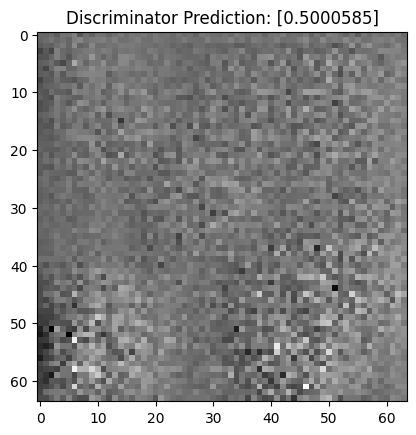

Image 77: Discriminator Prediction: [0.4999154]


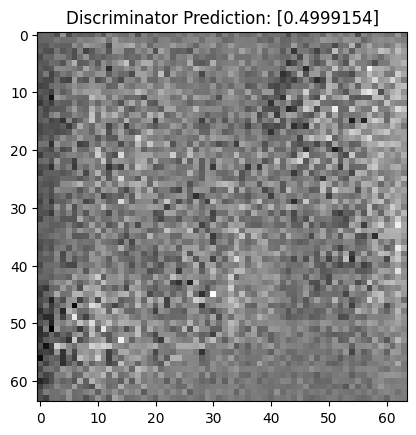

Image 78: Discriminator Prediction: [0.49995235]


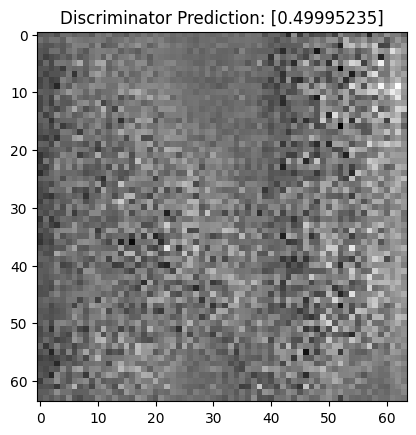

Image 79: Discriminator Prediction: [0.49996582]


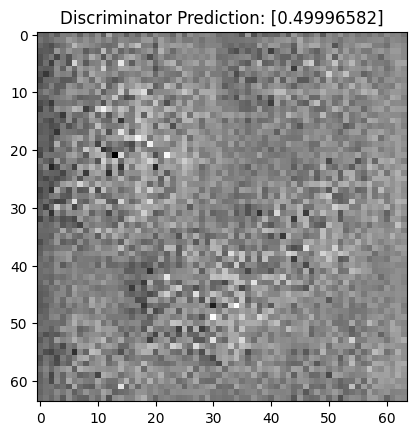

Image 80: Discriminator Prediction: [0.49970856]


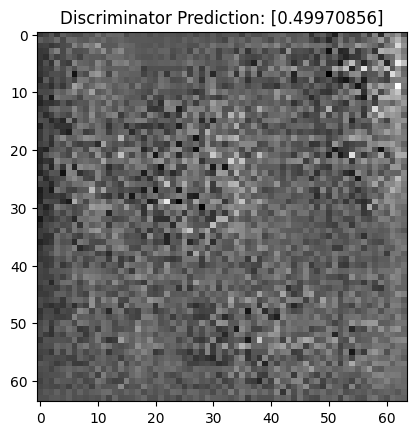

Image 81: Discriminator Prediction: [0.49991414]


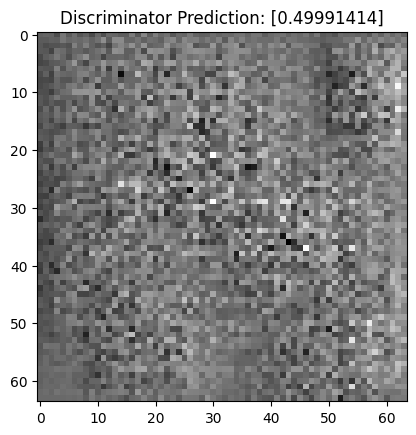

Image 82: Discriminator Prediction: [0.49984416]


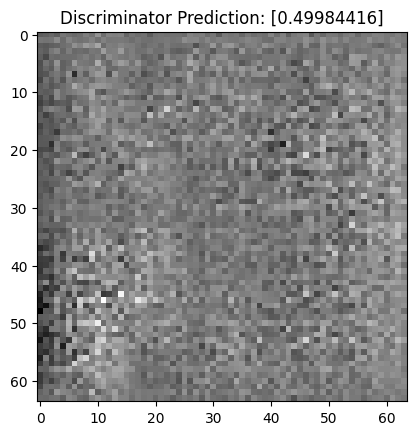

Image 83: Discriminator Prediction: [0.5000516]


KeyboardInterrupt: 

In [87]:
# Predict with the GAN discriminator on new generated images
gan_discriminator_predictions = gan_discriminator.predict(new_generated_images)

# Print and display predictions for the GAN discriminator
print("GAN Discriminator Predictions on New Generated Images:")
for i, prediction in enumerate(gan_discriminator_predictions):
    print(f"Image {i}: Discriminator Prediction: {prediction}")
    plt.imshow(new_generated_images[i].reshape(64, 64), cmap='gray')
    plt.title(f'Discriminator Prediction: {prediction}')
    plt.show()

# Print average prediction for GAN discriminator (assuming output is probability of being real)
average_prediction = np.mean(gan_discriminator_predictions)
print("GAN Discriminator Predictions on New Generated Images (average):")
print(f"Average prediction: {average_prediction}")
